---
# Esercitazione 10
---
## 10.1 TSP: The Salesman  Problem solved with Parallelized Genetic Algorithm
Nel primo punto di questa esercitazione viene implementato il protocollo MPI nel codice dell'esercitazione $9$, riguardante il problema del Commesso Viaggiatore risolto con l'Algoritmo Genetico. <br>
Vi sono le seguenti aggiunte dopo parallelizzazione dell'algoritmo:
- Il codice viene eseguito in parallelo fino a $10$ processi differenti, ognuno dei quali esegue una propria ricerca della miglior configurazione di viaggio.
- Dopo un numero $N_{migr}$ di generazioni, i vari processi, presi a coppie in modo casuale, si scambiano la miglior configurazione da loro trovata.
- Alla fine dell'esecuzione, avrò un file contenente le sequenze minime e le distanze trovate per ogni processo.

In linea di principio, la tecnica di parallelizzazione implementata dovrebbe velocizzare il codice, in quanto ogni processo esplora regioni differenti nello spazio delle configurazioni. Scambiarsi i migliori individui aumenta la probabilità che un processo finito in un minimo locale possa uscirne.

Di seguito vengono mostrati i risultati ottenuti con il nuovo algoritmo per il problema dell'esercitazione $9$, utilizzando $4$ processi. Successivamente viene cambiata la posizione delle città e il loro numero, usando infatti le $50$ capitali Americane.

La presenza di questo nuovo parametro $N_{migr}$ implica dover trovare anche per esso il valore migliore. Un valore troppo elevato renderebbe ininfluente l'effetto della parallelizzazione, mentre un valore troppo ridotto porterebbe ad un aumento nella velocità di convergenza del sistema, in quanto esso non ha il tempo per "assestarsi" tramite le mutazioni. La prima analisi viene effettuata utilizzando $4$ core e $N_{migr}=10$.

(OSS: dato che il codice è cambiato, per confrontare correttamente le due versioni, il programma viene eseguito con le medesime posizioni delle città trovate nell'esercitazione $9$.)


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Carico indice e coordinate per ogni città nelle due configurazioni, nel quadrato e sulla circonferenza
# Sono variabili globali
X_C, Y_C = np.loadtxt("./data_pm20_pc95_I1k_old/Circle/Positions.dat", unpack= True, usecols=(1,2), skiprows=1)
X_S, Y_S = np.loadtxt("./data_pm20_pc95_I1k_old/Square/Positions.dat", unpack= True, usecols=(1,2), skiprows=1)

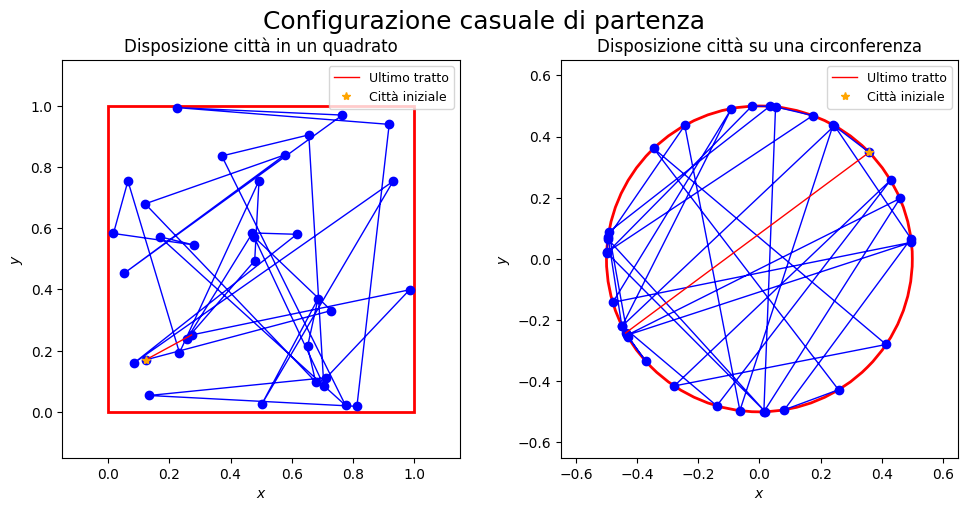

In [4]:

# Creazione dei subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

plt.suptitle("Configurazione casuale di partenza", size=18)

# Creazione del quadrato
square = plt.Rectangle((0, 0), 1, 1, fill=False, color='red', lw=2)
ax1.add_patch(square)
# ax1.scatter(X_S, Y_S, color='blue')
ax1.plot(X_S, Y_S, color='blue', marker="o", lw=1)
ax1.plot([X_S[-1], X_S[0]], [Y_S[-1], Y_S[0]], color='red', lw=1, label="Ultimo tratto")

ax1.plot(X_S[0], Y_S[0], "*", color='orange', label = "Città iniziale")
ax1.set_xlim(-0.15, 1.15)
ax1.set_ylim(-0.15, 1.15)
ax1.set_aspect('equal')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
ax1.set_title('Disposizione città in un quadrato')
ax1.legend(loc='upper right', prop={'size': 9})

# Creazione del cerchio
circle = plt.Circle((0, 0), 0.5, fill=False, color='red', lw=2)
ax2.add_patch(circle)
# ax2.scatter(X_C, Y_C, color='red')
ax2.plot(X_C, Y_C, color='blue', marker="o", lw=1)
ax2.plot([X_C[-1], X_C[0]], [Y_C[-1], Y_C[0]], color='red', lw=1, label="Ultimo tratto")

ax2.plot(X_C[0], Y_C[0], "*", color='orange',label = "Città iniziale")
ax2.set_xlim(-0.65, 0.65)
ax2.set_ylim(-0.65, 0.65)
ax2.set_aspect('equal')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
ax2.set_title('Disposizione città su una circonferenza')
ax2.legend(loc='upper right', prop={'size': 9})

# Mostrare i subplot
plt.tight_layout()
plt.show()


In [5]:
import matplotlib.pyplot as plt
import numpy as np


def lower_gen(distances: np.ndarray) -> list:
    """
    Funzione che prende il file letto da NumPy,
    carica ogni riga in una lista (le distanze di ogni generazione),
    e ritorna la prima metà di distanze
    """
    # Salvo ogni riga in una lista, corrisponde alle diverse generazioni
    generations = [list(row) for row in distances]
    dim = len(generations[0])
    # ordino le distanze per ogni generazione
    # for i in range(len(generations)): # NON serve perché lo fa già il codice C++
    #     generations[i].sort()
    generations = [row[:int(dim/2)] for row in generations]
    return generations


def PlotAveDist(distances_c: np.ndarray, distances_s: np.ndarray, title: str) -> None:
    """
    Funzione che crea il grafico delle distanze per le due configurazioni (cerchio e quadrato)
    al crescere delle generazioni. La distanza plottata è la media della prima metà di distanze più
    corte tra gli individual di una generazione insieme alla distanza minima di ogni generazione
    """

    generation_c = lower_gen(distances_c)
    generation_s = lower_gen(distances_s)

    min_dist_c = min(min(generation_c))
    min_dist_s = min(min(generation_s))

    print(f"Dist min cerchio: {min_dist_c}")
    print(f"Dist min quadrato: {min_dist_s}")

    x = np.arange(1, len(generation_c)+1)              #  x del grafico, numero della generazione
    av_dist_c = [np.mean(gen) for gen in generation_c] # distanza media per generazione sul cerchio
    av_dist_s = [np.mean(gen) for gen in generation_s] # distanza media per generazione nel quadrato

    m_dist_s = [min(gen) for gen in generation_s] # distanza minima per generazione
    m_dist_c = [min(gen) for gen in generation_c] # distanza minima per generazione


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    plt.suptitle(title, size=16)

    # grafico per la configurazione nel quadrato
    ax1.plot(x, av_dist_s, color='blue', label="Distanza media")
    ax1.scatter(x, m_dist_s, color="orange", s=3, label="Distanza minima per generazione")

    ax1.set_ylim(4.9, 7)
    ax1.set_xlabel('Generazioni', size=10)
    ax1.set_ylabel(r"$\langle L^{(1)} \rangle$", size=10)
    ax1.set_title(r"$\langle L^{(1)} \rangle$ all'aumentare delle generazioni (quadrato)", size=12)
    ax1.legend()
    ax1.grid()

    # grafico per la configurazione sul cerchio
    ax2.plot(x, av_dist_c, color='blue', label="Distanza media")
    ax2.scatter(x, m_dist_c, color="orange", s=3, label="Distanza minima per generazione")

    ax2.set_ylim(3, 6)
    ax2.set_xlabel('Generazioni', size=10)
    ax2.set_ylabel(r"$\langle L^{(1)} \rangle$", size=10)
    ax2.set_title(r"$\langle L^{(1)} \rangle$ all'aumentare delle generazioni (cerchio)", size=12)
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

In [6]:
def sequences_extractor(path: str) -> list:
    """
    Legge il file con le sequenze minime per generazione e restituisce una lista di dizionari,
    in cui in ognuno vi è la distanza e la sequenza.
    """
    with open(path) as seqFile:
        rows = seqFile.readlines()
        # contiene le sequenze di ogni popolazione, per ogni generazione (lista di liste di sequenze)
        gen_seq = []
        # per ogni riga letta dal file
        gen_seq = [{"distance": float(row.split()[0]), "sequence": row.split()[1],} for row in rows]
    return gen_seq


def min_sequence(sequences: list, shape=1) -> dict:
    """Estrae la configurazione con la distanza minore e la sua distanza"""
    min_dist = min(sequences, key=lambda x: x["distance"])
    if shape == 1:
        print(f"Dist min cerchio: {min_dist['distance']}")
        print(f"Sequenza: {min_dist['sequence']}")
    elif shape == 0:
        print(f"Dist min quadrato: {min_dist['distance']}")
        print(f"Sequenza: {min_dist['sequence']}")
    # elif shape == 3:
    #     print(f"Dist min tra capitali: {min_dist['distance']}")
    #     print(f"Sequenza: {min_dist['sequence']}")
    return min_dist

In [7]:
def path_plotter(sequence_dict_c:dict, sequence_dict_s:dict):
    """Funzione che disegna le sequenze di città nel quadrato e sul cerchio"""
    sequence_c = sequence_dict_c["sequence"].split("-")
    sequence_s = sequence_dict_s["sequence"].split("-")

    sequence_c = [int(index) for index in sequence_c]
    sequence_s = [int(index) for index in sequence_s]


    # Creazione dei subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Creazione del quadrato
    square = plt.Rectangle((0, 0), 1, 1, fill=False, color='red', lw=2)
    ax1.add_patch(square)
    # ax1.scatter(X_S, Y_S, color='blue')

    # creazione linee nell'ordine
    for i in range(len(sequence_s)):
        # indice attuale
        att = sequence_s[i]-1
        # indice precendete
        prec = sequence_s[i-1]-1
        ax1.plot([X_S[prec], X_S[att]], [Y_S[prec], Y_S[att]], color='blue', marker="o", lw=1)

    ax1.plot(0, 0, linewidth=1, label=r'$L^{(1)}_{min} = %.3f $' %(sequence_dict_s["distance"]), color="white")

    ax1.plot(X_S[0], Y_S[0], "*", color='orange', label = "Città iniziale")
    ax1.set_xlim(-0.15, 1.15)
    ax1.set_ylim(-0.15, 1.15)
    ax1.set_aspect('equal')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.set_title('Disposizione città in un quadrato')
    ax1.legend(loc='upper right', prop={'size': 9})

    # Creazione del cerchio
    circle = plt.Circle((0, 0), 0.5, fill=False, color='red', lw=2)
    ax2.add_patch(circle)
    # ax2.scatter(X_C, Y_C, color='red')

    # creazione linee nell'ordine
    for i in range(len(sequence_c)):
        # indice attuale
        att = sequence_c[i]-1
        # indice precendete
        prec = sequence_c[i-1]-1
        ax2.plot([X_C[prec], X_C[att]], [Y_C[prec], Y_C[att]], color='blue', marker="o", lw=1)

    ax2.plot(0, 0, linewidth=1, label=r'$L^{(1)}_{min} = %.3f $' %(sequence_dict_c["distance"]), color="white")

    ax2.plot(X_C[0], Y_C[0], "*", color='orange', label = "Città iniziale")
    ax2.set_xlim(-0.65, 0.65)
    ax2.set_ylim(-0.65, 0.65)
    ax2.set_aspect('equal')
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(r'$y$')
    ax2.set_title('Disposizione città su una circonferenza')
    ax2.legend(loc='upper right', prop={'size': 9})

    # Mostrare i subplot
    plt.tight_layout()
    plt.show()


Di seguito viene riportato il risultato dell'esercitazione 9, quindi senza implementazione MPI.

Dist min cerchio: 3.12153
Dist min quadrato: 5.08502


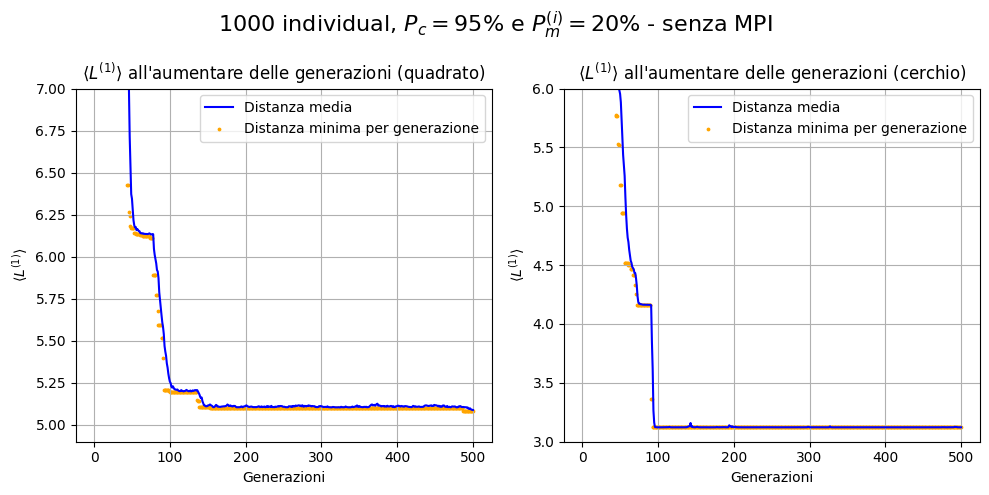

Dist min cerchio: 3.12153
Sequenza: 1-8-21-14-19-10-12-13-26-22-3-7-9-33-32-20-34-16-6-18-28-25-27-5-31-11-4-17-29-30-23-24-2-15-1
Dist min quadrato: 5.08502
Sequenza: 1-12-15-34-26-10-11-24-8-9-14-3-16-17-13-6-28-25-5-27-29-19-33-2-21-22-23-32-4-30-7-20-31-18-1


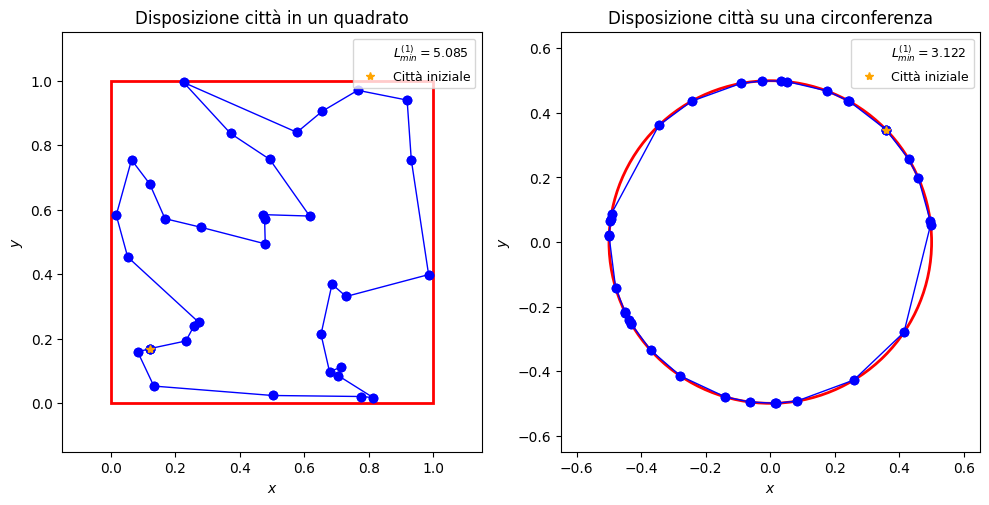

In [8]:
# Carico indice e coordinate per ogni città nelle due configurazioni, nel quadrato e sulla circonferenza
distances_Pm20Pc95I1k_c_old = np.loadtxt("./data_pm20_pc95_I1k_old/Circle/Distances.dat", skiprows=1)
distances_Pm20Pc95I1k_s_old = np.loadtxt("./data_pm20_pc95_I1k_old/Square/Distances.dat", skiprows=1)

PlotAveDist(distances_Pm20Pc95I1k_c_old, distances_Pm20Pc95I1k_s_old,"1000 individual, $P_{c}=95\%$ e $P^{(i)}_m = 20 \%$ - senza MPI")

# ottengo le distanze minime con relative sequenze
min_seq_Pm20Pc95I1k_c_old = min_sequence(sequences_extractor("./data_pm20_pc95_I1k_old/Circle/minSequences.dat"))
min_seq_Pm20Pc95I1k_s_old = min_sequence(sequences_extractor("./data_pm20_pc95_I1k_old/Square/minSequences.dat"), 0)

# disegno i percorsi ottenuti dall'algoritmo che minimizzano le distanze
path_plotter(min_seq_Pm20Pc95I1k_c_old, min_seq_Pm20Pc95I1k_s_old)

Il nuovo codice viene confrontato con il precedente, utilizzando le stessa configurazioni di probabilità, ovvero: $p_{c}=95\%$, $p_{m}=20\%$, $1000$ Individuals. Tra i $4$ processi utilizzati, si è scelto di riportare quello più rapido nella velocità di convergenza.

Dist min cerchio: 3.12153
Dist min quadrato: 4.9843


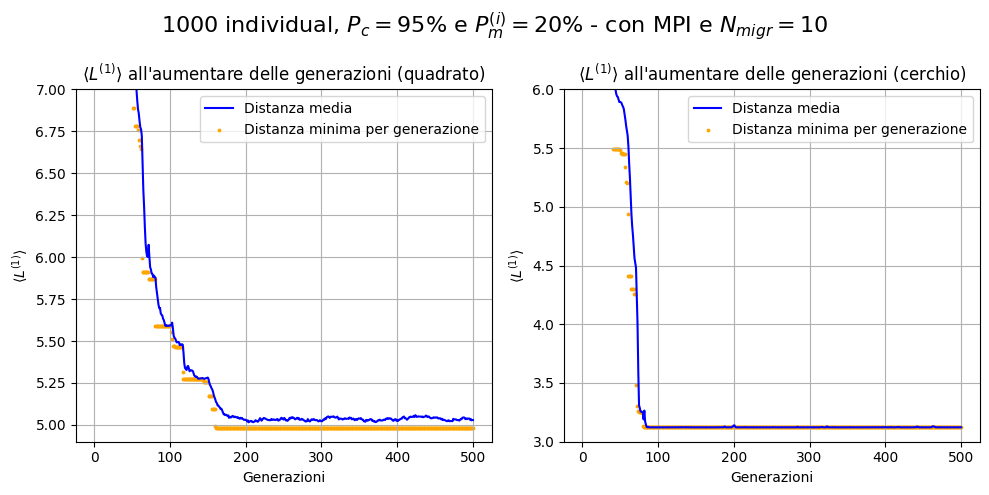

Dist min cerchio: 3.12153
Sequenza: 1-15-2-24-23-30-29-17-4-11-31-5-27-25-28-18-6-16-34-20-32-33-9-7-3-22-26-13-12-10-19-14-21-8-1
Dist min quadrato: 4.9843
Sequenza: 1-12-15-34-14-17-3-16-9-8-26-10-24-11-28-6-13-25-5-27-29-19-33-2-21-22-32-30-7-4-23-20-31-18-1


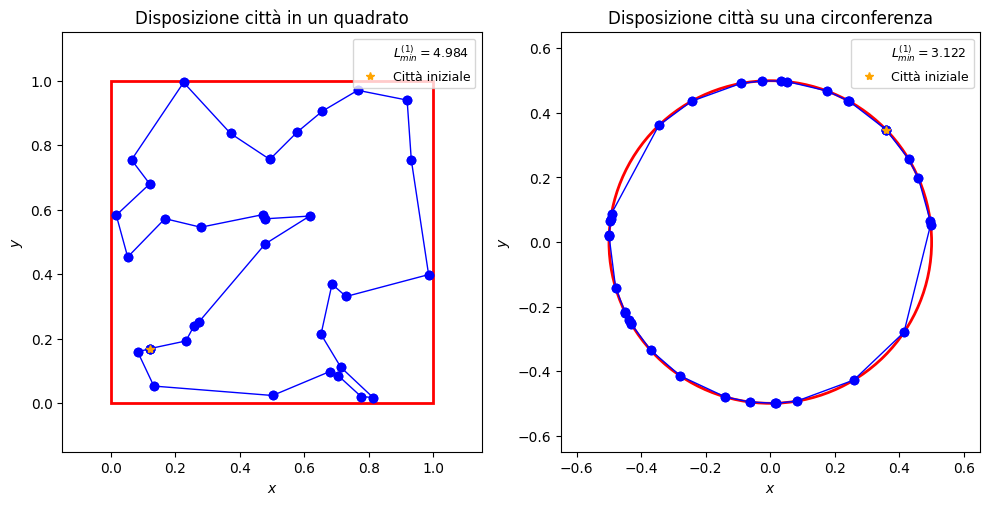

In [9]:
# Carico indice e coordinate per ogni città nelle due configurazioni, nel quadrato e sulla circonferenza
distances_Pm20Pc95I1k_c = np.loadtxt("./data_pm20_pc95_I1k/Circle/Distances_3.dat", skiprows=1)
distances_Pm20Pc95I1k_s = np.loadtxt("./data_pm20_pc95_I1k/Square/Distances_3.dat", skiprows=1)

PlotAveDist(distances_Pm20Pc95I1k_c, distances_Pm20Pc95I1k_s,"1000 individual, $P_{c}=95\%$ e $P^{(i)}_m = 20 \%$ - con MPI e $N_{migr}=10$")

# ottengo le distanze minime con relative sequenze
min_seq_Pm20Pc95I1k_c = min_sequence(sequences_extractor("./data_pm20_pc95_I1k/Circle/minSequences_3.dat"))
min_seq_Pm20Pc95I1k_s = min_sequence(sequences_extractor("./data_pm20_pc95_I1k/Square/minSequences_3.dat"), 0)

# disegno i percorsi ottenuti dall'algoritmo che minimizzano le distanze
path_plotter(min_seq_Pm20Pc95I1k_c, min_seq_Pm20Pc95I1k_s)

Osservando i risultati ottenuti, si può notare che il codice parallelizzato è leggermente più rapido, per entrambe le configurazioni. Inoltre la configurazione nel quadrato ha raggiunto una distanza inferiore a quanto già ottenuto.

Le analisi riguardo l'impatto sul valore di $N_{migr}$ verranno svolte nel prossimo punto.

## 10.2 TSP: The Salesman  Problem with 50 American Capitals
Come precedentemente annunciato, in questo punto viene affrontato lo stesso problema ma utilizzando le $50$ capitali Americane. Per questo punto vengono utilizzati $10$ processi.

Nel grafico che segue sono riportati i risultati ottenuti utilizzando li stessi parametri precendenti ($1000$ individui, $500$ generazioni $P_{c}=90\%$, $P_{m}=20\%$, $N_{migr}=10$) ma utilizzando $50$ città. <br>
Per semplificare l'analisi dei risultati, i risultati della media delle distanze per generazione vengono riportati sullo stesso grafico per ogni processo.


In [29]:
import matplotlib.pyplot as plt
import numpy as np


def lower_gen(distances: np.ndarray) -> list:
    """
    Funzione che prende il file letto da NumPy,
    carica ogni riga in una lista (le distanze di ogni generazione),
    e ritorna la prima metà di distanze
    """
    # Salvo ogni riga in una lista, corrisponde alle diverse generazioni
    generations = [list(row) for row in distances]
    dim = len(generations[0])
    # ordino le distanze per ogni generazione
    # for i in range(len(generations)): # NON serve perché lo fa già il codice C++
    #     generations[i].sort()
    generations = [row[:int(dim/2)] for row in generations]
    return generations


def PlotAveDistMPI(distances: list, title: str, ylim = (25000, 35000)) -> None:
    """
    Funzione che crea il grafico delle distanze al crescere delle generazioni plottando tutti i 
    risultati ottenuti nei vari processi. Per ogni processo, la distanza plottata è la media della
    prima metà di distanze più corte tra gli individual di una generazione insieme alla distanza minima
    di ogni generazione. In ingresso devo specificare la lista di distanze caricate da ogni processo
    """
    # numero processi utilizzati
    core = len(distances)

    # lista che contiene per ogni processo una lista (le generazioni) di liste (le distanze di ogni individuo)
    # di quest'ultime la prima metà più corta
    generations = [lower_gen(dist) for dist in distances]
    # lista che contiene per ogni processo il minimo di ogni generazione
    min_dists = [min(min(gen)) for gen in generations]

    for i, minD in enumerate(min_dists):
        print(f"Dist min processo {i}: {minD}")

    # lista che contiene per ogni processo la lista con le medie della distanza per ogni generazione
    av_dists = []
    # lista che contiene per ogni processo la lista con le distanze minime per generazione
    m_dists = []
    for c in range(core):
        av_dists.append([np.mean(gen) for gen in generations[c]]) # distanza media per generazione
        m_dists.append([min(gen) for gen in generations[c]]) # distanza minima per generazione

    plt.figure(figsize=(10, 5))
    
    plt.suptitle(title, size=16)

    x = np.arange(1, len(generations[0])+1)              #  x del grafico, numero della generazione
    # creo il grafico
    # lista di 10 colori perché so che questo è il massimo numero di core utilizzati
    colors = ['k', 'g', 'r', 'c', 'm', 'y', 'b', 'purple', 'orange', 'brown']

    for c in range(core):
        if c == 0:
            plt.plot(x, av_dists[c], color=colors[c], label=f"Dist media (core {c})")
            plt.scatter(x, m_dists[c], color=colors[c], s=3, label=f"Dist min")
        else:
            plt.plot(x, av_dists[c], color=colors[c], label=f"core {c}")
            plt.scatter(x, m_dists[c], color=colors[c], s=3)

    plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Generazioni', size=10)
    plt.ylabel(r"$\langle L^{(1)} \rangle$", size=10)
    plt.title(r"$\langle L^{(1)} \rangle$ all'aumentare delle generazioni", size=12)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


def minSeqMPI(paths_list: list) -> dict:
    """
    Estrae la sequenza a distanza minima tra tutti i file generati dai vari processi.
    In ingresso do la lista con i percorsi dei file minSequences
    """
    # salvo in una lista la configurazione con distanza minima di ogni processo
    min_seqs = [min_sequence(sequences_extractor(minSeq), shape=3) for minSeq in paths_list]
    # estraggo la configurazione a distanza minima tra tutti i processi
    min_seq = min_seqs[0]
    for seq in min_seqs:
        if seq["distance"] < min_seq["distance"]:
            min_seq = seq

    return min_seq
        

import cartopy.crs as ccrs

def path_plotter_capitals(sequence_dict:dict, filename = 'American_capitals.dat'):
    """Funzione che disegna una sequenza di capitali sulla cartina"""
    sequence = sequence_dict["sequence"].split("-")
    sequence = [int(index) for index in sequence]

    # Carico le coordinate delle capitali con longitudine e latitudine
    capital_data = []

    with open(filename, 'r') as file:
        # Se carico le città americane salto la prima riga (intestazione)
        if filename == 'American_capitals.dat':
            next(file)
        
        # Leggo il file riga per riga
        for line in file:
            # Separo ogni riga in base agli spazi
            parts = line.split()
            # Salvo i dati, ma il file delle città italiane non ha i vari nomi
            # in entrambi i file lon e lat sono agli ultimi due posti
            lon = float(parts[-2])
            lat = float(parts[-1])
            if filename == 'American_capitals.dat':
                name = parts[0]
                description = parts[1]
            else:
                name = None
                description = None
            
            city_dict = {"city": description, "lon": lon, "lat": lat}
            capital_data.append(city_dict)

    # Calcola i limiti dell'area da visualizzare
    lons = [capital["lon"] for capital in capital_data]
    lats = [capital["lat"] for capital in capital_data]
    min_lon, max_lon = min(lons) - 2.5, max(lons) + 5
    min_lat, max_lat = min(lats) - 2.5, max(lats) + 2.5

    # Crea una mappa con proiezione geografica e limiti
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Disegna la mappa di sfondo
    ax.coastlines(resolution='10m', linewidth=0.3)

    # creazione linee congiungenti le città nell'ordine della sequenza
    for i in range(len(sequence)):
        # indice attuale
        att = sequence[i]-1
        # indice precendete
        prec = sequence[i-1]-1
        ax.plot([capital_data[prec]["lon"], capital_data[att]["lon"]], [capital_data[prec]["lat"], capital_data[att]["lat"]], color='orange', lw=1)

    # Disegna un punto per ogni capitale con relativa etichetta per il nome delle città americane
    for capital in capital_data:
        ax.plot(capital["lon"], capital["lat"], 'o', markersize=3, color="red", transform=ccrs.PlateCarree())
        # le città italiane non hanno nome
        if filename == 'American_capitals.dat':
            ax.text(capital["lon"], capital["lat"], capital["city"], fontsize=6, color='blue', transform=ccrs.PlateCarree())

    ax.plot(0, 0, linewidth=1, label=r'$L^{(1)}_{min} = %.2f$ Km' %(sequence_dict["distance"]), color="white")

    ax.set_title("TSP result")
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.legend(loc='upper center', prop={'size': 12})

    # Visualizza la mappa
    plt.tight_layout()
    plt.show()



In [14]:
# salvo il numero di processi utilizzati
nproc = 10
path_Distances = ["./Americas/Am_N10_10c/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSequences = ["./Americas/Am_N10_10c/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N10_10c = [np.loadtxt(dist, skiprows=1) for dist in path_Distances]
minSeq_N10_10c = minSeqMPI(path_minSequences)

print(minSeq_N10_10c)


{'distance': 26650.7, 'sequence': '1-18-24-4-36-43-31-3-44-28-5-11-2-47-37-12-26-6-50-41-33-23-49-15-27-16-25-13-42-17-14-22-35-48-38-34-45-19-29-21-39-7-30-8-20-46-32-40-10-9-1'}


Dist min processo 0: 26988.66992
Dist min processo 1: 26988.66992
Dist min processo 2: 26988.66992
Dist min processo 3: 26988.66992
Dist min processo 4: 26650.72852
Dist min processo 5: 26650.72852
Dist min processo 6: 26988.66992
Dist min processo 7: 26988.66992
Dist min processo 8: 26988.66992
Dist min processo 9: 26988.66992


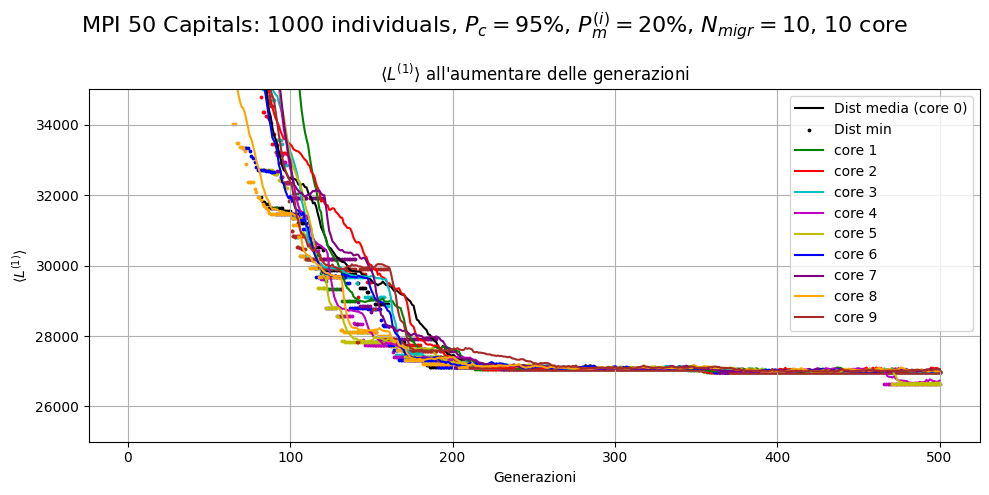

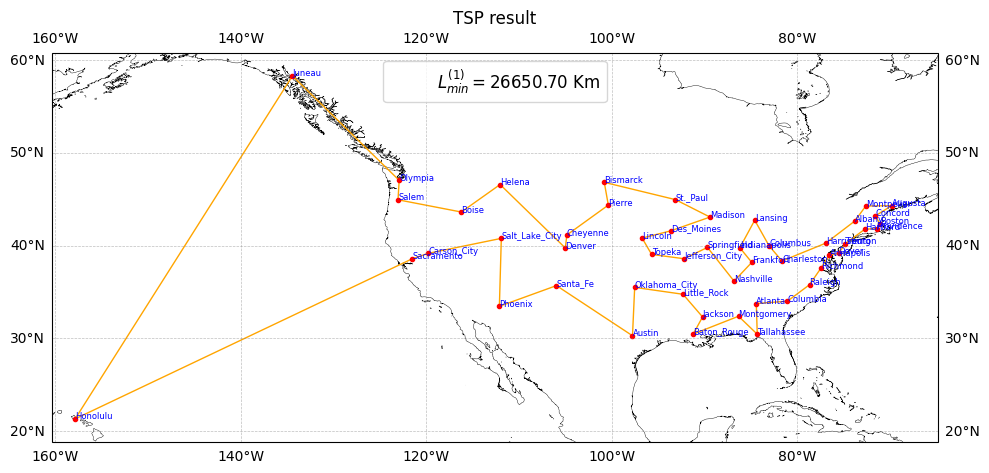

In [30]:
PlotAveDistMPI(distances_N10_10c, "MPI 50 Capitals: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=10$, $10$ core")
path_plotter_capitals(minSeq_N10_10c)

Com'è possibile notare, la velocità di convergenza è simile per ogni nodo. Si nota che un primo minimo della distanza percorsa viene raggiunto dopo circa $200$ generazioni, e resta costante fino a circa $460$ alla quale viene trovato un minimo inferiore. <br>
Di seguito vengono mostrati i risultati aumentato il valori di $N_{migr}$ a $20$, utilizzando sempre $10$ precessi.

In [31]:
# salvo il numero di processi utilizzati
nproc = 10
path_Dist_N20_10c = ["./Americas/Am_N20_10c/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSeq_N20_10c = ["./Americas/Am_N20_10c/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N20_10c = [np.loadtxt(dist, skiprows=1) for dist in path_Dist_N20_10c]
minSeq_N20_10c = minSeqMPI(path_minSeq_N20_10c)

print(minSeq_N20_10c)


{'distance': 26539.5, 'sequence': '1-10-42-17-14-13-25-4-24-18-43-36-16-15-27-50-6-31-3-28-5-11-2-47-37-12-44-26-33-41-23-49-22-35-48-20-38-34-45-19-29-21-39-7-30-8-46-32-40-9-1'}


Dist min processo 0: 26539.50977
Dist min processo 1: 26539.50977
Dist min processo 2: 26539.50977
Dist min processo 3: 26713.14648
Dist min processo 4: 26539.50977
Dist min processo 5: 26539.50977
Dist min processo 6: 26539.50977
Dist min processo 7: 26539.50977
Dist min processo 8: 26539.50977
Dist min processo 9: 26713.14648


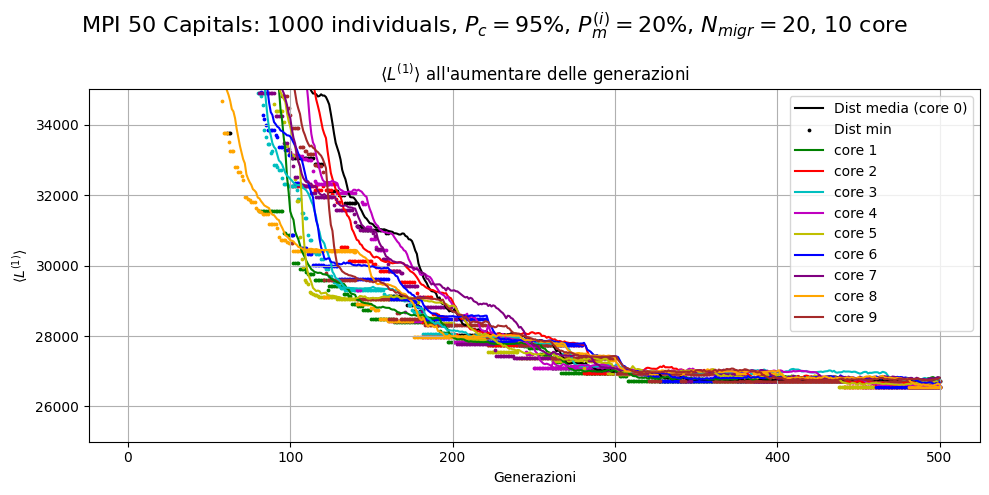

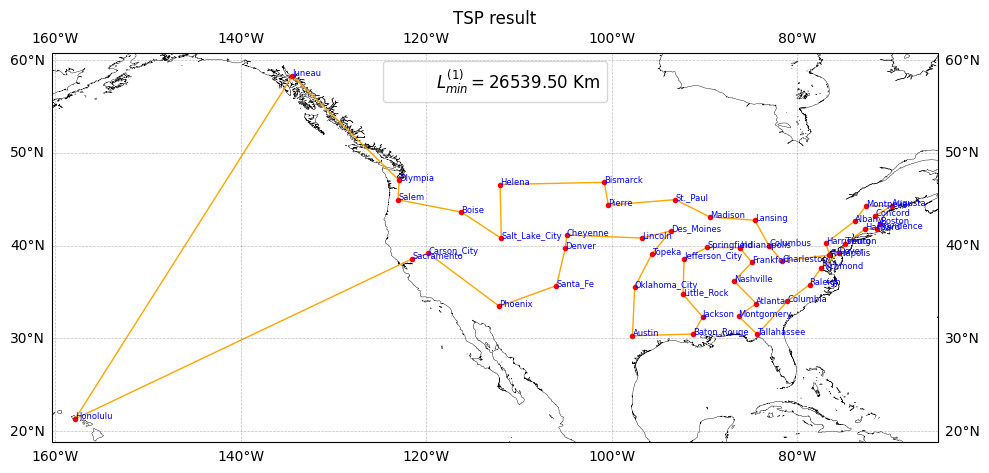

In [32]:
PlotAveDistMPI(distances_N20_10c, "MPI 50 Capitals: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=20$, $10$ core")
path_plotter_capitals(minSeq_N20_10c)

Incrementando il numero di generazioni dopo la quale avviene uno scambio, l'algoritmo sembra essersi globalmente rallentato, in quanto il primo minimo viene ora raggiunto in circa $350$ generazioni. Tuttavia, raggiunge un minimo globale più basso dopo meno generazioni (circa $430$).

Di seguito viene mostrato il risultato ottenuto incrementando ulteriormente $N_{migr}$ e portandolo a $30$.

In [34]:
# salvo il numero di processi utilizzati
nproc = 10
path_Dist_N30_10c = ["./Americas/Am_N30_10c/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSeq_N30_10c = ["./Americas/Am_N30_10c/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N30_10c = [np.loadtxt(dist, skiprows=1) for dist in path_Dist_N30_10c]
minSeq_N30_10c = minSeqMPI(path_minSeq_N30_10c)

print(minSeq_N30_10c)


{'distance': 26329.7, 'sequence': '1-10-42-4-24-18-43-36-31-3-28-5-11-2-47-37-12-26-44-6-50-41-33-23-15-27-16-25-13-49-22-14-17-35-48-38-7-39-21-29-19-45-34-30-8-20-46-32-40-9-1'}


Dist min processo 0: 26351.56641
Dist min processo 1: 26351.56641
Dist min processo 2: 26454.74609
Dist min processo 3: 26454.74609
Dist min processo 4: 26414.3125
Dist min processo 5: 26329.68945
Dist min processo 6: 26454.74609
Dist min processo 7: 26329.68945
Dist min processo 8: 26329.68945
Dist min processo 9: 26329.68945


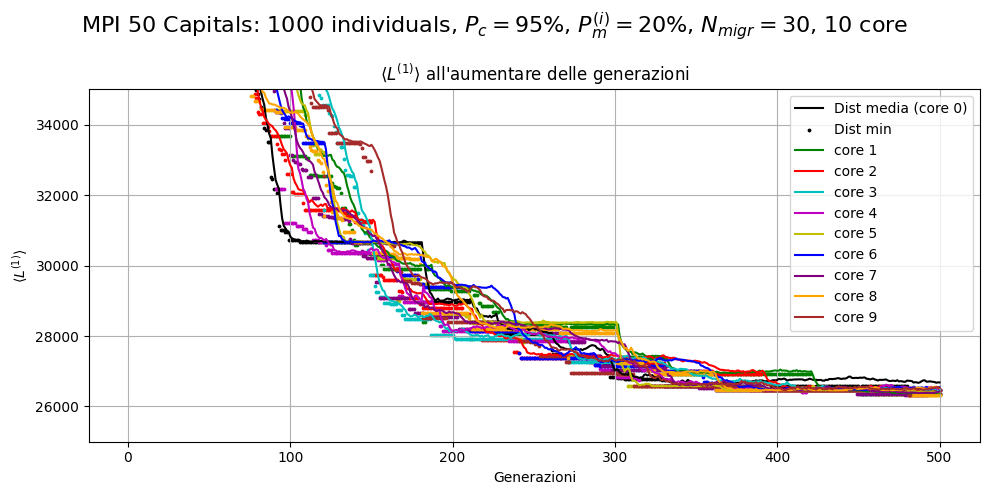

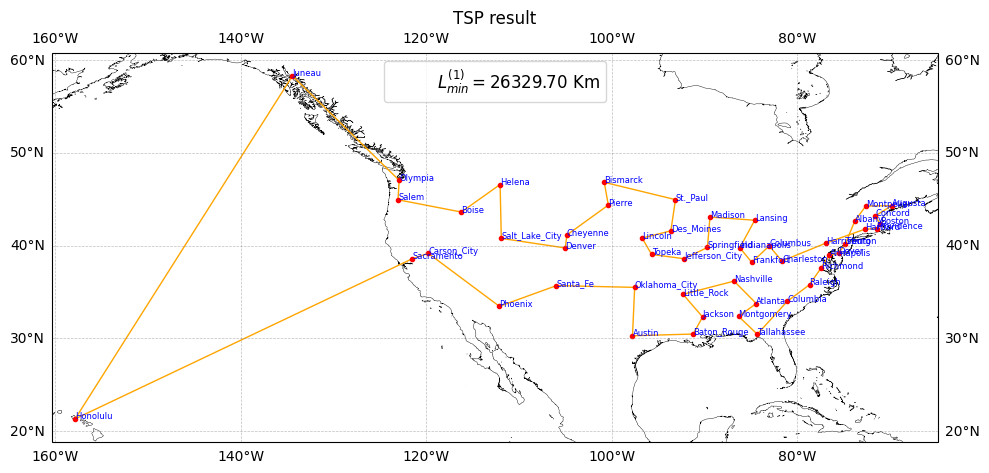

In [35]:
PlotAveDistMPI(distances_N30_10c, "MPI 50 Capitals: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=30$, $10$ core")
path_plotter_capitals(minSeq_N30_10c)

L'andamento sembra confermarsi: la convergenza sembra rallentata ma il minimo globale ottenuto è inferiore.

Come ultimo tentativo per grandi valori di $N_{migr}$ viene riportato il risultato per $50$.

In [36]:
# salvo il numero di processi utilizzati
nproc = 10
path_Dist_N50_10c = ["./Americas/Am_N50_10c/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSeq_N50_10c = ["./Americas/Am_N50_10c/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N50_10c = [np.loadtxt(dist, skiprows=1) for dist in path_Dist_N50_10c]
minSeq_N50_10c = minSeqMPI(path_minSeq_N50_10c)

print(minSeq_N50_10c)


{'distance': 26368.7, 'sequence': '1-18-24-4-36-43-31-3-28-5-11-2-47-37-12-26-44-6-50-41-33-23-49-15-27-16-25-13-42-17-14-22-35-48-38-34-45-19-29-21-39-7-30-8-20-46-32-40-10-9-1'}


Dist min processo 0: 26368.6543
Dist min processo 1: 26368.6543
Dist min processo 2: 26368.6543
Dist min processo 3: 26368.6543
Dist min processo 4: 26368.6543
Dist min processo 5: 26398.74805
Dist min processo 6: 26398.74805
Dist min processo 7: 26368.6543
Dist min processo 8: 26368.6543
Dist min processo 9: 26368.6543


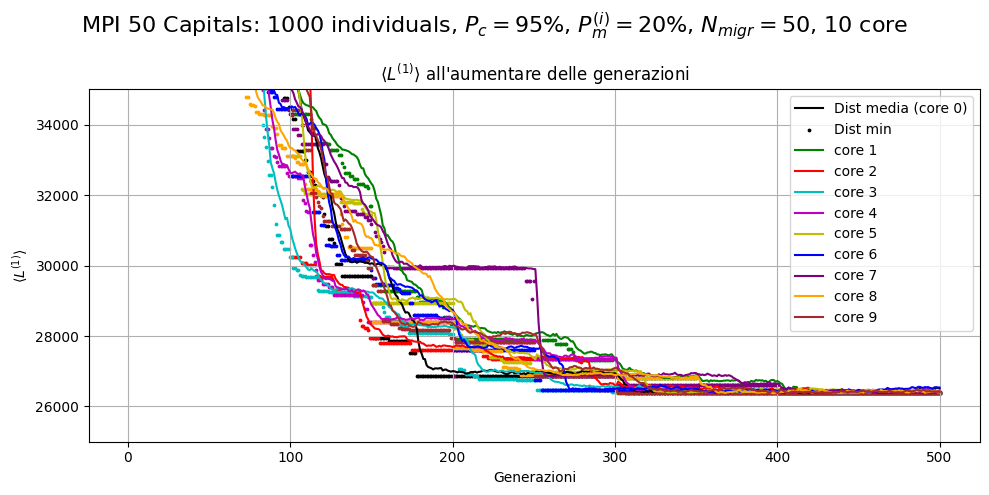

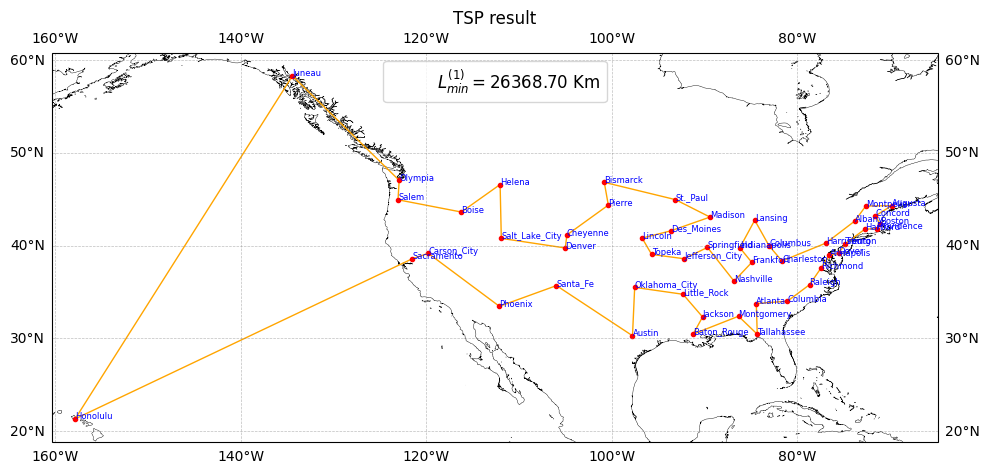

In [37]:
PlotAveDistMPI(distances_N50_10c, "MPI 50 Capitals: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=50$, $10$ core")
path_plotter_capitals(minSeq_N50_10c)

Contro le previsioni da trend osservato, in questa configurazione sembra si sia raggiunto il valore di minimo (leggermente più alto, ma confrontabile con quanto raggiunto in precedenza) in meno generazioni, ovvero circa $300$.<br>
Un'altra osservazione interessante riguarda l'andamento dei risultati del core $7$, si nota infatti che esso sembra essersi stabilizzato in un minimo locale per un tempo pari a $2\cdot N_{migr}$. Si può ipotizzare che la riduzione della frequenza di comunicazione tra i processi abbia aumentato la durata di persistenza nel minimo di questo specifico core.

Come precedentemente annunciato, ci si aspetta un andamento migliore per valori non troppo elevati di $N_{migr}$, per questo motivo di seguito vengono riportati i risultati nel caso limite, ovvero con $N_{migr}=1$.

In [38]:
# salvo il numero di processi utilizzati
nproc = 10
path_Dist_N1_10c = ["./Americas/Am_N1_10c/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSeq_N1_10c = ["./Americas/Am_N1_10c/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N1_10c = [np.loadtxt(dist, skiprows=1) for dist in path_Dist_N1_10c]
minSeq_N1_10c = minSeqMPI(path_minSeq_N1_10c)

print(minSeq_N1_10c)


{'distance': 26864.1, 'sequence': '1-10-42-17-14-13-25-4-24-18-43-36-31-3-11-2-47-37-5-28-12-26-44-6-50-33-41-27-16-15-23-49-22-35-48-38-7-39-21-29-19-45-34-30-8-20-46-32-40-9-1'}


Dist min processo 0: 26864.07422
Dist min processo 1: 26864.07422
Dist min processo 2: 26864.07422
Dist min processo 3: 26864.07422
Dist min processo 4: 26864.07422
Dist min processo 5: 26864.07422
Dist min processo 6: 26864.07422
Dist min processo 7: 26864.07422
Dist min processo 8: 26864.07422
Dist min processo 9: 26864.07422


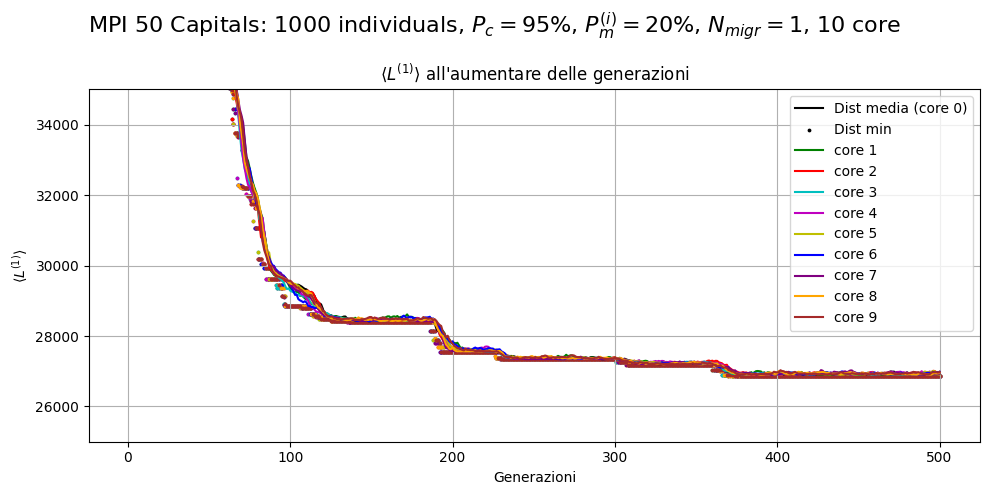

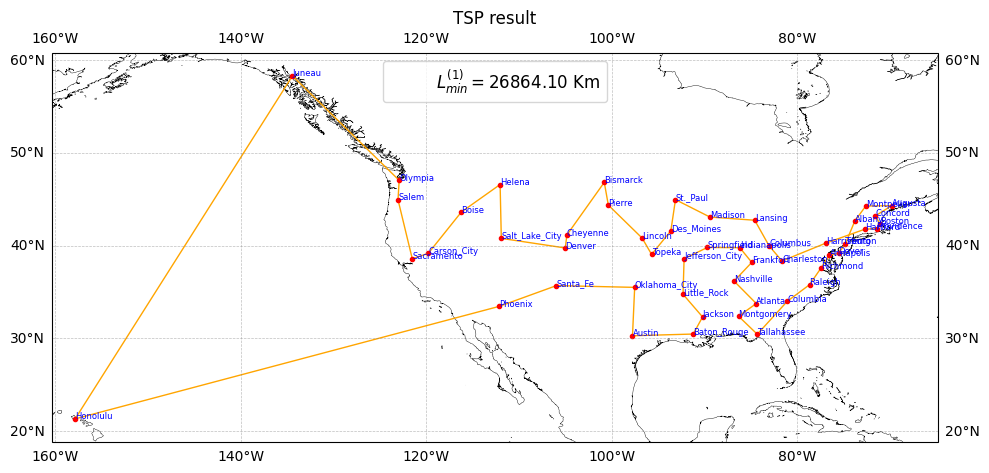

In [39]:
PlotAveDistMPI(distances_N1_10c, "MPI 50 Capitals: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=1$, $10$ core")
path_plotter_capitals(minSeq_N1_10c)

Com'era possibile prevedere, una comunicazione costante tra i processi porta ad un'elevata correlazione tra i risultati. La curva della distanza per generazione è infatti meno diffusa rispetto ai casi precedenti. Si nota inoltre che il problema non ha sicuramente raggiunto un minimo "globale" in quanto vi è un intersezione tra traiettorie.

Di seguito viene mostrato il risultato, sempre di 10 processi, ma in assenza di comunicazioni collettive, ovvero i $10$ risultati ottenuti sono tra loro indipendenti.

In [40]:
# salvo il numero di processi utilizzati
nproc = 10
path_Dist_N0_10c = ["./Americas/Am_N0_10c/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSeq_N0_10c = ["./Americas/Am_N0_10c/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N0_10c = [np.loadtxt(dist, skiprows=1) for dist in path_Dist_N0_10c]
minSeq_N0_10c = minSeqMPI(path_minSeq_N0_10c)

print(minSeq_N0_10c)


{'distance': 27099.7, 'sequence': '1-24-18-43-36-16-33-26-12-37-47-2-11-5-28-44-3-31-6-50-41-27-15-23-49-22-35-14-13-25-4-42-17-48-38-34-45-19-29-21-39-7-30-8-20-46-32-40-10-9-1'}


Dist min processo 0: 27555.20312
Dist min processo 1: 28195.58789
Dist min processo 2: 27173.62891
Dist min processo 3: 28084.58008
Dist min processo 4: 28442.23242
Dist min processo 5: 28147.69531
Dist min processo 6: 27099.66602
Dist min processo 7: 27810.41211
Dist min processo 8: 28174.55469
Dist min processo 9: 27317.43164


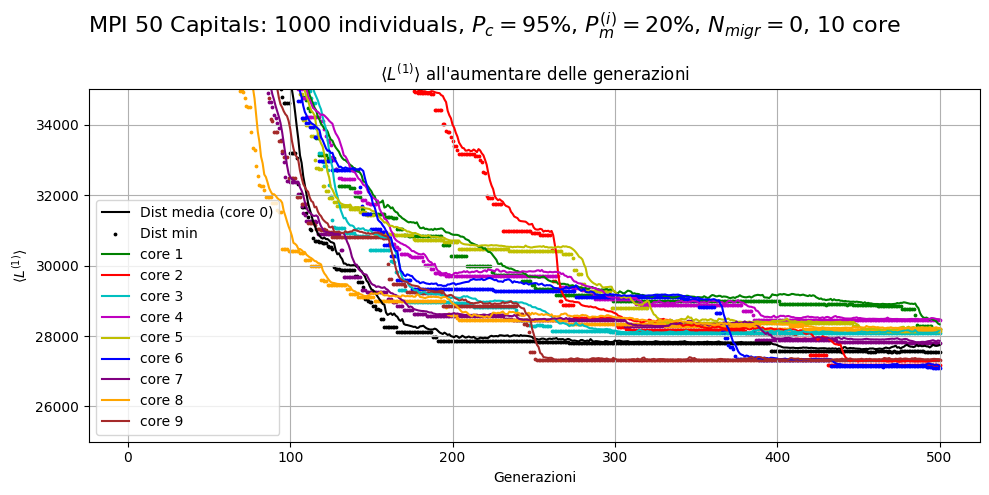

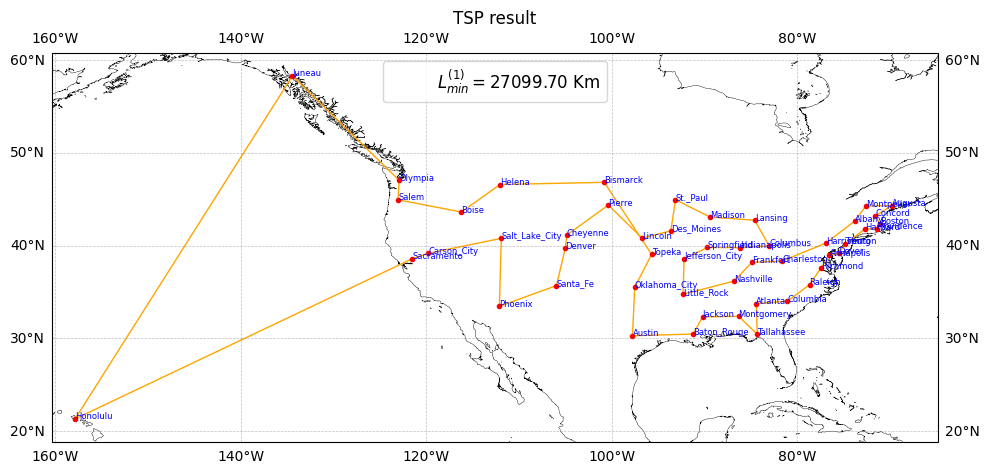

In [41]:
PlotAveDistMPI(distances_N0_10c, "MPI 50 Capitals: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=0$, $10$ core")
path_plotter_capitals(minSeq_N0_10c)

Analizzando anche l'ultimo risultato, si ha la conferma che le comunicazioni rallentano la velocità del processo ma evitano all'algoritmo di fermarsi per troppo tempo in minimi locali. Infatti, in questo caso con comunicazioni assenti, si ottiene un andamento stabile dopo circa $250$ generazioni, ma la sequenza minima estratta è la più lunga trovata tra le varie configurazioni testate.

Un'analisi ulteriore, qui non riportata, consiste nell'estendere il numero di generazioni a $1000$ nel setup che ha garantito la sequenza con distanza minore. Tuttavia la distanza ottenuta è invariata.

## Conclusioni
Dai risultati ottenuti, si può confermare e concludere che:
- L'utilizzo del protocollo MPI non aumenta significativamente la velocità di convergenza dell'algoritmo.
- Le comunicazioni tra processi evitano che il sistema stia per troppo tempo in un minimo locale. Dunque, globalmente la parallelizzazione come introdotta migliora la "qualità" della convergenza, ottenendo una sequenza di lunghezza inferiore.
- Una frequenza troppo elevata delle comunicazioni collettive ($N_{migr} \in [0;10]$), porta a un'eccessiva correlazione tra i risultati.
- La larghezza di dispersione maggiore tra le linee (media delle distanze per generazione) riflette un range maggiore nell'esplorazione delle possibili configurazioni (linee distanti implicano distanze medie diverse tra i processi, ovvero configurazioni diverse). Con comunicazioni continue si è ottenuta la maggior uniformità tra le linee, ovvero distanze medie molto simili e dunque in media le configurazioni estratte sono simili, rendendo poco efficace l'utilizzo di un protocollo MPI. Con comunicazioni assenti si è ottenuta la dispersione maggiore tra le linee, ovvero sequenze esplorate mediamente molto diverse, ma a minor velocità di convergenza.
- Complessivamente la parallelizzazione introdotta ha migliorato l'algoritmo precedente.

## 10.3 TSP: The Salesman Problem con 110 Comuni Italiani
Come punto bonus viene ora riproposto l'algoritmo ma utilizzando come città i $110$ Comuni Italiani, utilizzando gli stessi parametri usati prima ma mostrando i risultati per $500$ individui per generazione.

{'distance': 13147.4, 'sequence': '1-20-32-78-91-24-80-56-28-10-71-84-60-86-76-12-38-26-9-55-93-18-47-30-25-108-66-98-97-87-88-62-19-22-64-63-110-95-67-79-3-90-41-49-51-44-50-59-29-65-40-101-70-33-82-69-5-77-83-85-75-16-13-48-57-74-34-99-100-102-37-42-39-68-61-31-89-2-107-92-4-81-54-7-14-106-105-103-27-11-104-17-96-72-53-109-15-58-73-35-36-8-23-94-6-52-45-46-43-21-1'}
Dist min processo 0: 13173.36328
Dist min processo 1: 13462.25488
Dist min processo 2: 13147.36816
Dist min processo 3: 13318.73633


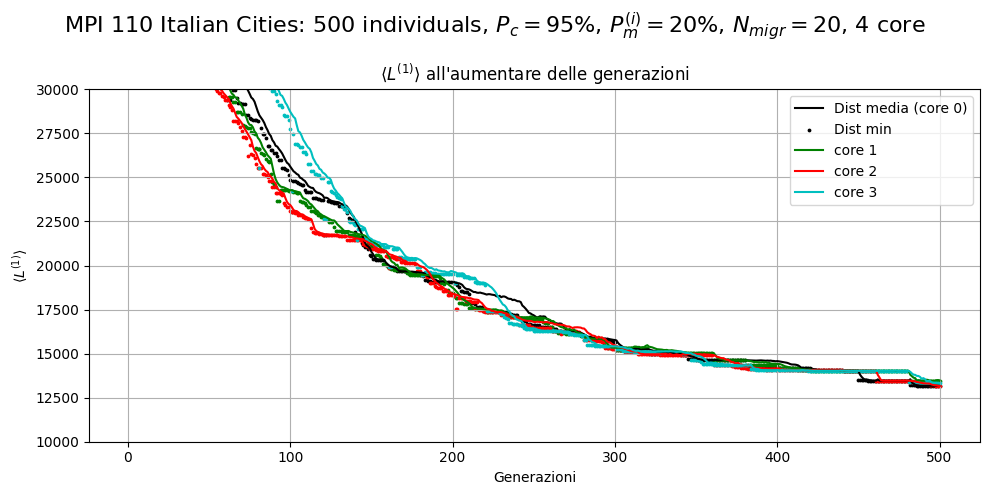

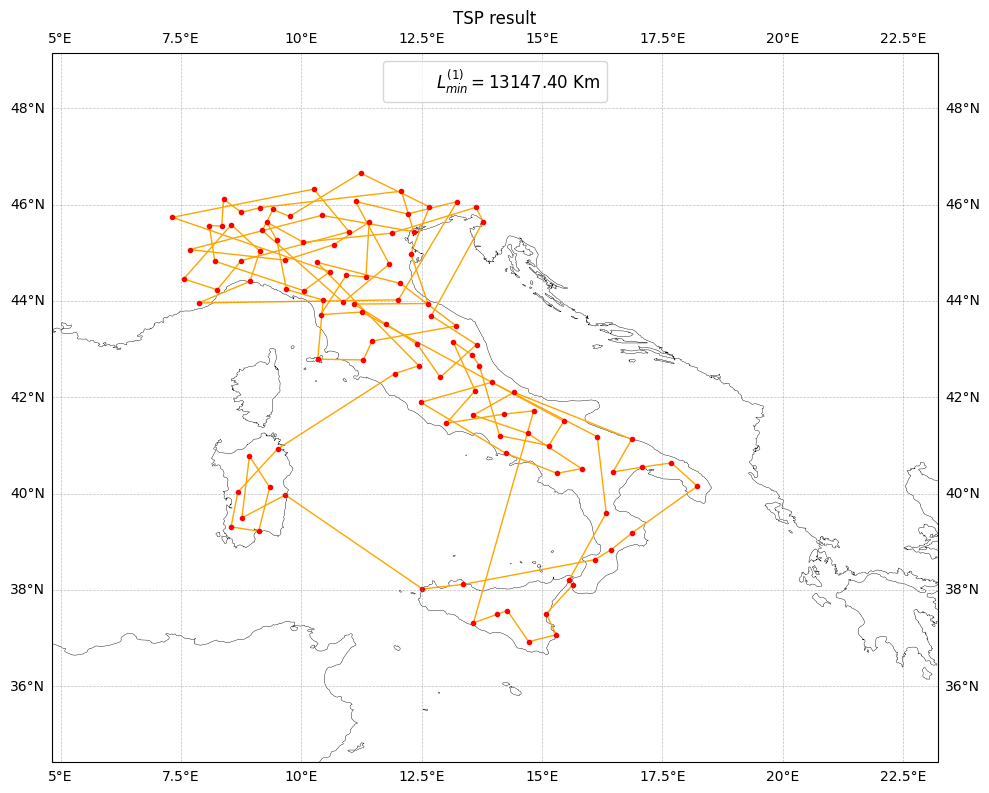

In [45]:
# salvo il numero di processi utilizzati
nproc = 4
path_Distances = ["./ItalianCities/IT_N20_4c_I500/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSequences = ["./ItalianCities/IT_N20_4c_I500/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N20_4c_I500_ITA = [np.loadtxt(dist, skiprows=1) for dist in path_Distances]
minSeq_N20_4c_I500_ITA = minSeqMPI(path_minSequences)

print(minSeq_N20_4c_I500_ITA)

PlotAveDistMPI(distances_N20_4c_I500_ITA, "MPI 110 Italian Cities: 500 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=20$, $4$ core", \
                    ylim = (10000, 30000))
path_plotter_capitals(minSeq_N20_4c_I500_ITA, filename='./cap_prov_ita.dat')

Come è possibile notare, le configurazioni utilizzate non sono sufficienti a far convergere il sistema. Prima di provare a svolgere più generazioni si mostra di seguito il risultato con il doppio degli individui, ovvero 1000 per generazione, a parità di tutti gli altri parametri.

{'distance': 10715.3, 'sequence': '1-66-98-19-22-87-97-62-64-88-63-38-26-21-36-10-86-8-12-46-84-82-71-33-52-95-110-69-70-83-37-79-54-7-17-53-81-57-72-51-49-41-77-39-29-67-15-5-85-107-65-104-92-13-2-89-42-106-103-16-105-61-68-31-96-4-14-50-100-75-101-40-102-99-58-44-73-90-35-74-34-11-48-27-59-109-3-6-94-45-43-23-60-76-55-18-47-25-28-9-93-30-108-56-80-24-91-78-32-20-1'}
Dist min processo 0: 10983.42773
Dist min processo 1: 10983.42773
Dist min processo 2: 10845.34766
Dist min processo 3: 10715.29297


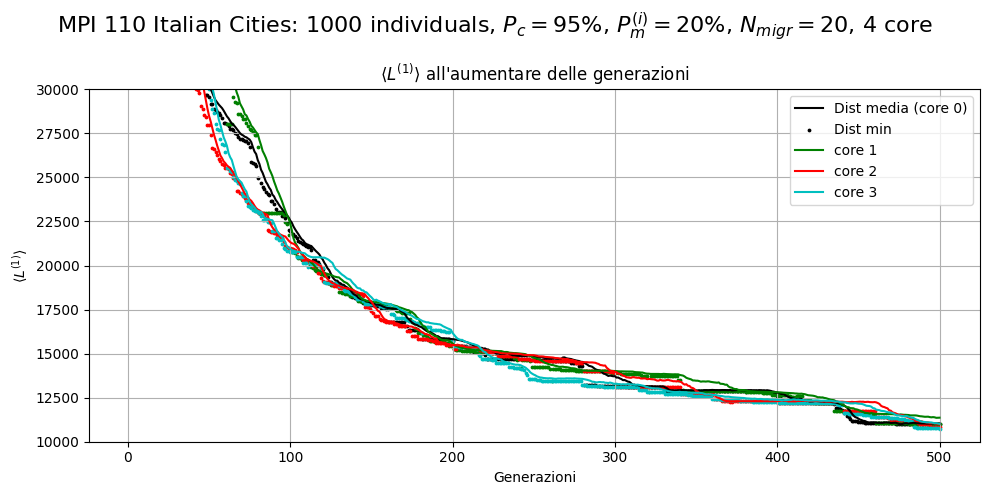

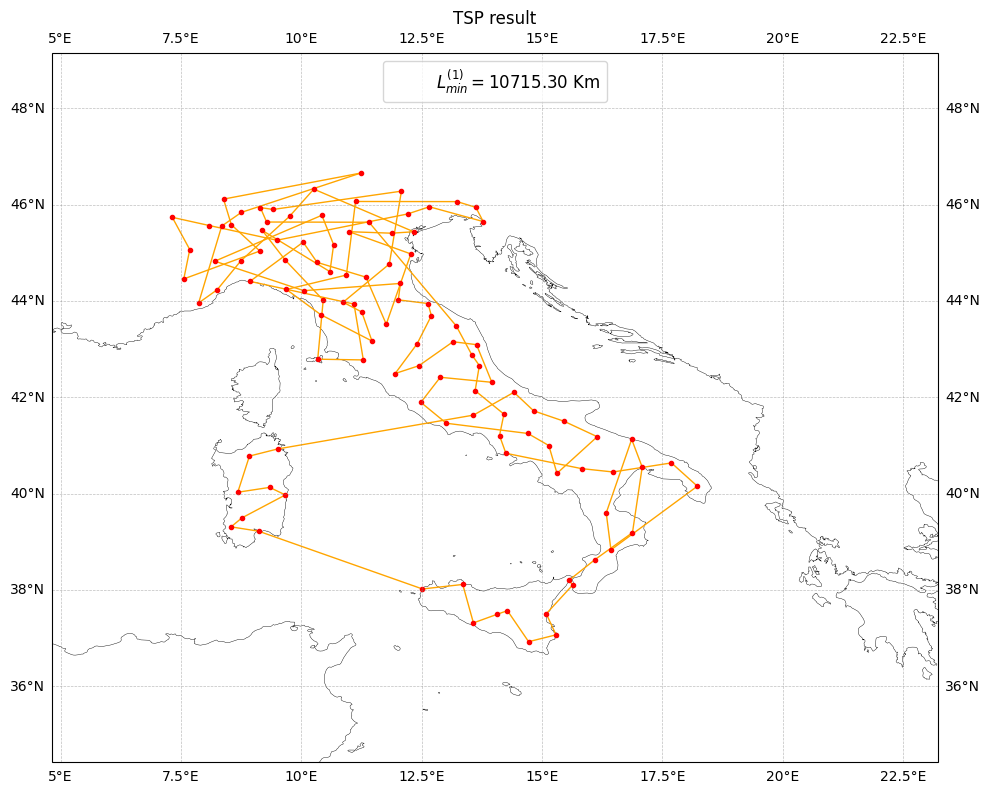

In [46]:
# salvo il numero di processi utilizzati
nproc = 4
path_Distances = ["./ItalianCities/IT_N20_4c_I1k/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSequences = ["./ItalianCities/IT_N20_4c_I1k/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N20_4c_I1k_ITA = [np.loadtxt(dist, skiprows=1) for dist in path_Distances]
minSeq_N20_4c_I1k_ITA = minSeqMPI(path_minSequences)

print(minSeq_N20_4c_I1k_ITA)

PlotAveDistMPI(distances_N20_4c_I1k_ITA, "MPI 110 Italian Cities: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=20$, $4$ core", \
                    ylim = (10000, 30000))
path_plotter_capitals(minSeq_N20_4c_I1k_ITA, filename='./cap_prov_ita.dat')

Come è possibile notare, aumentare a $1000$ il numero di individui per generazione ha permesso di abbassare notevolmente la distanza minima raggiunta, tuttavia il codice ha ancora problemi a convergere. Di seguito vengono mostrati i risultati ottenuti raddoppiando il numero di generazioni a $1000$.

{'distance': 8716.29, 'sequence': '1-66-98-19-22-87-97-62-64-88-63-49-41-90-35-74-72-57-29-67-39-14-4-96-31-68-16-105-103-106-61-50-100-75-101-40-102-109-99-17-53-15-81-54-44-73-77-58-34-65-107-92-7-42-89-2-59-27-48-13-11-104-85-51-5-37-79-83-70-69-110-95-52-3-33-6-94-71-45-82-84-46-38-43-26-21-36-10-76-55-47-18-9-86-8-12-23-60-93-28-30-25-108-56-80-24-91-78-32-20-1'}
Dist min processo 0: 8716.28809
Dist min processo 1: 8716.28809
Dist min processo 2: 8782.36035
Dist min processo 3: 8782.36035


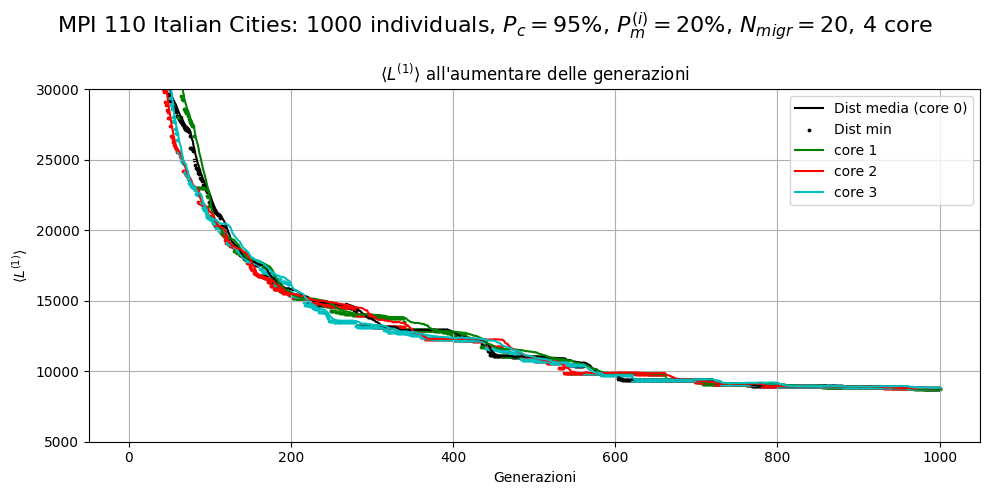

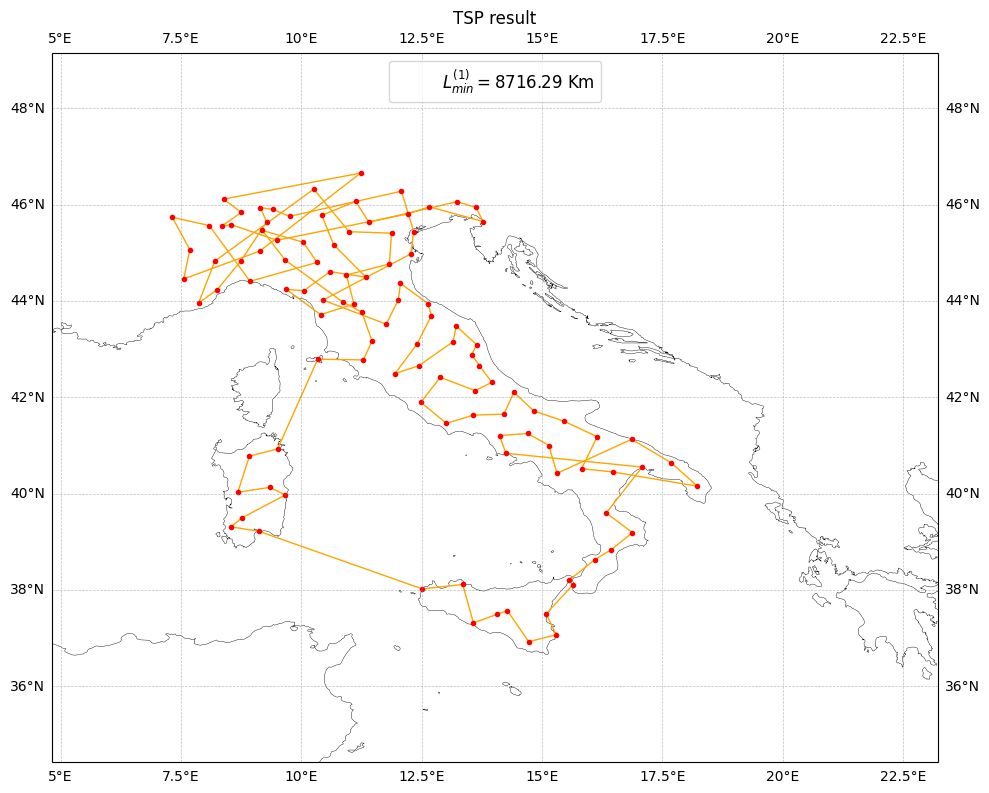

In [48]:
# salvo il numero di processi utilizzati
nproc = 4
path_Distances = ["./ItalianCities/IT_N20_4c_I1k_Gen1k/Distances_"+str(i)+".dat" for i in range(nproc)]
path_minSequences = ["./ItalianCities/IT_N20_4c_I1k_Gen1k/minSequences_"+str(i)+".dat" for i in range(nproc)]

# Carico le distanze ottenute da ogni processo
distances_N20_4c_I1k_Gen1k_ITA = [np.loadtxt(dist, skiprows=1) for dist in path_Distances]
minSeq_N20_4c_I1k_Gen1k_ITA = minSeqMPI(path_minSequences)

print(minSeq_N20_4c_I1k_Gen1k_ITA)

PlotAveDistMPI(distances_N20_4c_I1k_Gen1k_ITA, "MPI 110 Italian Cities: 1000 individuals, $P_{c}=95\%$, $P^{(i)}_m = 20 \%$, $N_{migr}=20$, $4$ core", \
                    ylim = (5000, 30000))
path_plotter_capitals(minSeq_N20_4c_I1k_Gen1k_ITA, filename='./cap_prov_ita.dat')

Aumentando le generazioni si nota un'ulteriore riduzione della distanza, tuttavia il codice non converge ancora. Da queste analisi si deduce che il codice dev'essere ulteriormente migliorato nel caso di alto numero di città.